In [ ]:
!pip install kagglehub --quiet

In [ ]:
from kagglehub import dataset_download
import os

path = dataset_download("mateuszbuda/lgg-mri-segmentation")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/lgg-mri-segmentation


In [ ]:
print("Top-level contents:", os.listdir(path))

DATASET_DIR = os.path.join(path, "kaggle_3m")

Top-level contents: ['kaggle_3m', 'lgg-mri-segmentation']


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
def load_data_recursive(base_dir):
    image_files = []
    mask_files = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".tif"):
                full_path = os.path.join(root, file)
                if "_mask" in file:
                    mask_files.append(full_path)
                else:
                    image_files.append(full_path)

    image_files = sorted(image_files)
    mask_files = sorted(mask_files)

    print(f"Found {len(image_files)} images and {len(mask_files)} masks.")

    X, Y = [], []
    for img_path in image_files:
        base_name = os.path.basename(img_path).replace(".tif", "")
        mask_name = base_name + "_mask.tif"
        mask_path = os.path.join(os.path.dirname(img_path), mask_name)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        X.append(img)
        Y.append(mask)

    return np.array(X), np.array(Y)

In [ ]:
X, Y = load_data_recursive(DATASET_DIR)
print("Loaded dataset:", X.shape, Y.shape)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape)

Found 3929 images and 3929 masks.
Loaded dataset: (3929, 128, 128, 3) (3929, 128, 128, 1)
Train: (3143, 128, 128, 3) Val: (786, 128, 128, 3)


In [ ]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)

    model = models.Model(inputs, outputs, name='UNet')
    return model

In [ ]:
model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=8)

Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 80s 151ms/step - accuracy: 0.9730 - loss: 0.1487 - val_accuracy: 0.9918 - val_loss: 0.0251
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.9921 - val_loss: 0.0257
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.9916 - loss: 0.0257 - val_accuracy: 0.9914 - val_loss: 0.0293
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.9915 - loss: 0.0250 - val_accuracy: 0.9927 - val_loss: 0.0207
Epoch 5/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.9926 - loss: 0.0218 - val_accuracy: 0.9928 - val_loss: 0.0225
Epoch 6/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.9929 - loss: 0.0202 - val_accuracy: 0.9916 - val_loss: 0.0247
Epoch 7/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - accuracy: 0.9938 - loss: 0.0158 - val_accuracy: 0.9941 - val_loss: 0.0180
Epoch 8/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.9946 - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


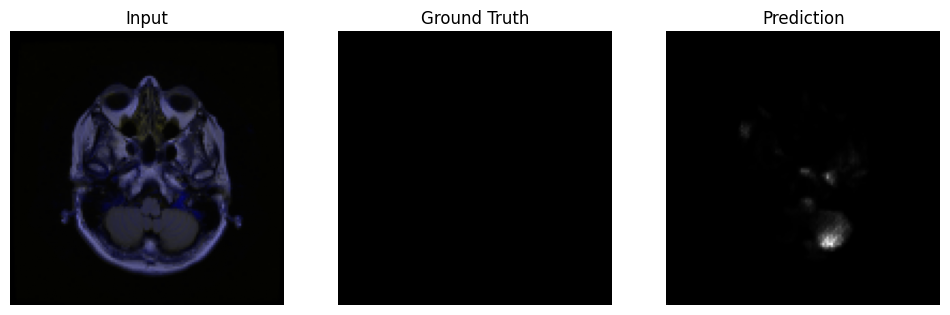

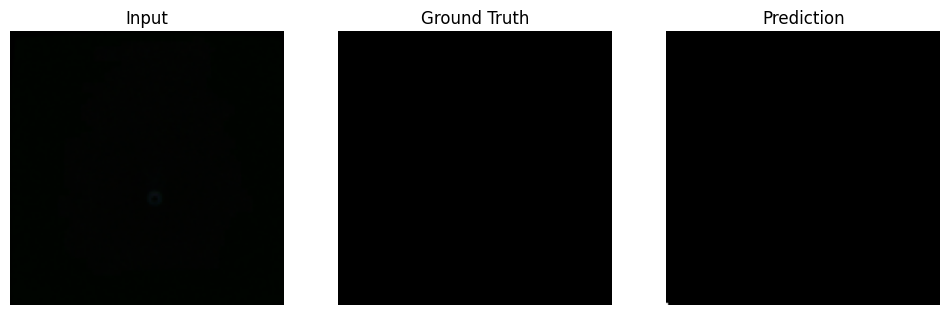

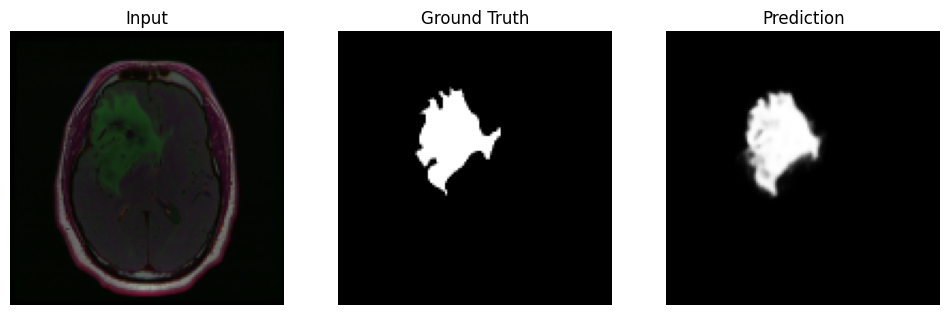

In [ ]:
def show_predictions(X, Y_true, model, num=3):
    preds = model.predict(X[:num])
    for i in range(num):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title('Input')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(Y_true[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.show()

show_predictions(X_val, Y_val, model)